# Tracks

In [185]:
import pickle

import scipy
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
from shapely.geometry import *

import utils.track_utils as utils

# Import Track file

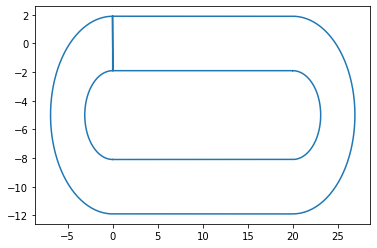

In [15]:
with open("tracks/track1.pickle",'rb') as infile:
    centerline = pickle.load(infile)

polygon = utils.centerline_to_polygon(centerline)
plt.plot(*polygon.T)

# Define car model

In [648]:
from scipy import optimize
from collections import defaultdict

def angle_diff(x, y):
    return (x - y + np.pi) % (2*np.pi) - np.pi

def car_dot(state: np.array, u: np.array, params: dict):
    """ Dynamics for a kinematic bicycle model of 1 meter length
    
    https://borrelli.me.berkeley.edu/pdfpub/IV_KinematicMPC_jason.pdf
    
    state description: 0: x, 1: y, 2: theta, 3: v
    input_description: 0: acc, 1: steer
    """
    
    wheel_base = params["wheel_base"]
    
    beta = np.arctan(0.5 * np.tan(u[1]))
    
    x_dot = state[3] * np.cos(state[2] + beta)
    y_dot = state[3] * np.sin(state[2] + beta)
    theta_dot = 2 * state[3] * np.sin(beta) / wheel_base
    v_dot = u[0]
    state_dot = [x_dot, y_dot, theta_dot, v_dot]
    
    return np.array(state_dot)

def controller(state: np.array, centerline: np.array, params: dict, information: defaultdict):
    
    lookahead_distance = params['lookahead_distance']
    lookahead_gain = params['lookahead_gain']
    steer_gain = params['steer_gain']
    wheel_base = params['wheel_base']
    target_speed = params['target_speed']
    
    centerline_lr = LinearRing(centerline)
    
    # Get rear axle
    rear_x = state[0] - (wheel_base / 2) * np.cos(state[2])
    rear_y = state[1] - (wheel_base / 2) * np.sin(state[2])
    point_rear = Point(rear_x, rear_y)
    tang_dist = centerline_lr.project(point_rear)
    
    # Get current point on centerline for search
    current_point = centerline_lr.interpolate(tang_dist)
    
    # Update Lookahead distance depending on speed
    lookahead = lookahead_gain * state[3] * lookahead_distance
    
    def distance(point_rear, current_point):
        return np.hypot(current_point.y - point_rear.y, 
                        current_point.x - point_rear.x)
    # Make circle bigger until you reached the desired lookahead
    dist = distance(point_rear, current_point)
    while lookahead > dist:
        tang_dist = (tang_dist + 1) % centerline_lr.length
        current_point = centerline_lr.interpolate(tang_dist)
        dist = distance(point_rear, current_point)

    # Pure pursuit https://arxiv.org/pdf/1604.07446.pdf 
    alpha_ref = np.arctan2((current_point.y - point_rear.y), 
                           (current_point.x - point_rear.x))
    
    # Get theta in -pi pi range
    theta = np.arctan2(np.sin(state[2]), np.cos(state[2]))
    
    alpha = angle_diff(alpha_ref, theta)
    curvature = 2 * np.sin(alpha) / lookahead_distance
    
    # Constant acceleration
    steer = steer_gain * np.arctan2(curvature * wheel_base, 1)
    accel = target_speed - state[3]
    
    information["opt_tan_dist"].append(tang_dist)
    information["alpha_ref"].append(alpha_ref)
    information["alpha"].append(alpha)
    information["lookahead_computed"].append(dist)
    information["lookahead"].append(lookahead)
    information["lookahead_points"].append(current_point)
    return np.array([accel, steer])

def get_state_trajectory(information, state_keys):
    state_trajectory = defaultdict(list)
    for state in information["state"]:
        for i, k in enumerate(state_keys):
            state_trajectory[k].append(state[i])
    return state_trajectory

def get_input_trajectory(information, input_keys):
    input_trajectory = defaultdict(list)
    for inputs in information["inputs"]:
        for i, k in enumerate(input_keys):
            input_trajectory[k].append(inputs[i])
    return input_trajectory

## Simulate and plot trajectory

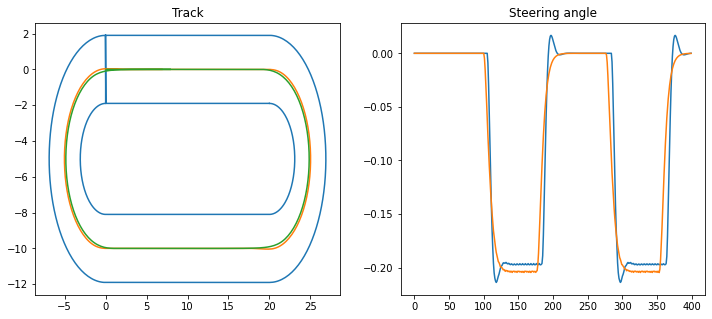

In [658]:
import copy
from collections import namedtuple
    
initial_state = np.array([0, 0, 0, 0.5])
delta_t = 0.1

# Plot track
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*polygon.T)

for gain in np.linspace(0.1, 0.8, 2):
    params = dict(lookahead_distance=1,
                  lookahead_gain=gain,
                  steer_gain=1,
                  wheel_base=1,
                  target_speed=2)

    information = defaultdict(list)
    state = copy.deepcopy(initial_state)

    for _ in range(400):
        inputs = controller(state, centerline, params, information)
        state = state + delta_t * car_dot(state, inputs, params)

        information["state"].append(state)
        information["inputs"].append(inputs)

    state_keys = ['x', 'y', 'theta', 'v']
    state_trajectory = get_state_trajectory(information, state_keys)

    input_keys = ['accel', 'steer']
    input_trajectory = get_input_trajectory(information, input_keys)

    ax[0].plot(state_trajectory['x'], state_trajectory['y'])
    ax[0].set_title("Track")
    ax[1].plot(input_trajectory['steer'])
    ax[1].set_title("Steering angle")
        
plt.show()